In [13]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json 
import ipywidgets as wdg


# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [14]:
#function to convert a date string into a pandas datetime object
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

FROM JSON FILE

In [15]:
#load the data
with open("admissions.json", "rt") as INFILE:
    admissions=json.load(INFILE)
with open("cases.json", "rt") as INFILE:
    cases=json.load(INFILE)
with open("deaths.json", "rt") as INFILE:
    deaths=json.load(INFILE)

with open("influenzaAdmission.json", "rt") as INFILE:
    influenzaAdmissions=json.load(INFILE)   
with open("bedsDay.json", "rt") as INFILE:
    bedsDay=json.load(INFILE)
    
#compare the pcr tests for covid and influenza
with open("CovidPCRlatest.json", "rt") as INFILE:
    CovidPCR=json.load(INFILE)
with open("influenzaPCRlatest.json", "rt") as INFILE:
    influenzaPCR=json.load(INFILE)

#deaths for years
with open("deaths_2022.json", "rt") as INFILE:
    deaths_2022=json.load(INFILE)
with open("deaths_2023.json", "rt") as INFILE:
    deaths_2023=json.load(INFILE)
with open("deaths_2024.json", "rt") as INFILE:
    deaths_2024=json.load(INFILE)


WRANGLE ANY TWO DATA

<Axes: >

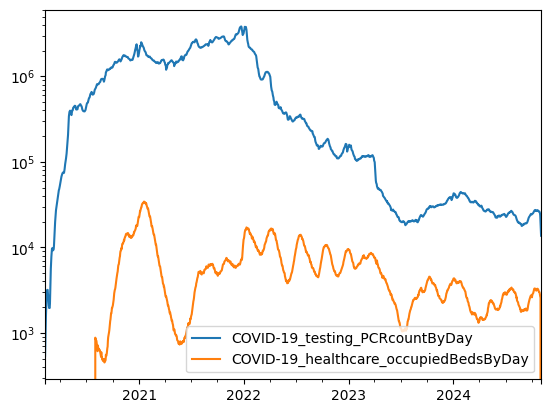

In [16]:


def wrangle_data_two(rawdata, anotherdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Edit to include the code that wrangles the data, creates the dataframe and fills it in. """
#create a new dictionary to store the data
    newJson={}
    metricList=[]
    for dataset in [rawdata, anotherdata]:
        for entry in dataset:
            date=entry["date"]
            metric=entry["metric"]
            value =entry["metric_value"]
            if date not in newJson:
                newJson[date]={}
            newJson[date][metric]=value
            if metric not in metricList:
                metricList.append(metric)
    
    #dates
    dates=list(newJson.keys())
    dates.sort()
    
     #convert start and end dates to pandas format for the index data range
    startDate=parse_date(dates[0])
    endDate=parse_date(dates[-1])
    
    
    index = pd.date_range(startDate, endDate, freq='D')
    df=pd.DataFrame(index=index, columns=[metric for metric in metricList])
    metrics ={metric:metric for metric in metricList}
    
    for date, entry in newJson.items(): # each entry is a dictionary with cases, admissions and deaths
        pd_date=parse_date(date) # convert to Pandas format
        for column in [metric for metric in metricList]: # each column is a metric
            metric_name=metrics[column]
            # do not assume all values are there for every date - if a value is not available, insert a 0.0
            value= entry.get(metric_name, 0.0)
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
            df.loc[date, column]=value
    # fill in any remaining "holes" due to missing dates
    df.fillna(0.0, inplace=True)
    return df
df=wrangle_data_two(CovidPCR, bedsDay) # df is the dataframe for plotting
df.plot(logy=True)

WRANGLE ONE DATA AND REFRESH

In [17]:
import requests
import time

class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # build the path with all the required structure parameters. You do not need to edit this line,
        # parameters will be replaced by the actual values when you instantiate an object of the class!
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=5):
        """ Access the API and download the next page of data. Sets the count
        attribute to the total number of items available for this query. Changing
        filters or page_size will cause get_page to restart from page 1. Rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365); use the default value 
        for debugging your structure and filters. """
        # Check page size is within range
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return [] # we already fetched the last page
        # simple rate limiting to avoid bans
        curr_time=time.time() # Unix time: number of seconds since the Epoch
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # the page parameter is already included in _next_url.
        # This is the API access. Response is a dictionary with various keys.
        # the .json() method decodes the response into Python object (dictionaries,
        # lists; 'null' values are translated as None).
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

    def get_all_pages(self, filters={}, page_size=365):
        """ Access the API and download all available data pages of data. Sets the count
        attribute to the total number of items available for this query. API access rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365), and controls the trade-off
        between time to load a page and number of pages; the default should work well 
        in most cases. The number of items returned should in any case be equal to 
        the count attribute. """
        data=[] # build up all data here
        while True:
            # use get_page to do the job, including the pacing
            next_page=self.get_page(filters, page_size)
            if next_page==[]:
                break # we are done
            data.extend(next_page)
        return data

In [18]:
def wrangle_data(rawdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Edit to include the code that wrangles the data, creates the dataframe and fills it in. """
    #convert the combined data into a pandas dataframe
    newJson={}
    for entry in rawdata:
        date=entry["date"]
        metric=entry["metric"]
        value =entry["metric_value"]
        if date not in newJson:
            newJson[date]={}
        newJson[date][metric]=value
        
    dates=list(newJson.keys())
    dates.sort()

    #convert start and end dates to pandas format for the index data range
    startDate=parse_date(dates[0])
    endDate=parse_date(dates[-1])
    
    metrics ={'Covid': metric}
    
    index = pd.date_range(startDate, endDate, freq='D')
    df=pd.DataFrame(index=index, columns=['Covid'])
    
    for date, entry in newJson.items(): # each entry is a dictionary with cases, admissions and deaths
        pd_date=parse_date(date) # convert to Pandas format
        for column in ['Covid']: 
            metric_name=metrics[column]
            # do not assume all values are there for every date - if a value is not available, insert a 0.0
            value= entry.get(metric_name, 0.0)
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
            df.loc[date, column]=value
    # fill in any remaining "holes" due to missing dates
    df.fillna(0.0, inplace=True)
    return df

In [19]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 

def access_api( topic, metric):
       try:
              # """ Accesses the UKHSA API. Return data as a like-for-like replacement for the "canned" data loaded from the JSON file. """
              structure={"theme": "infectious_disease", 
                     "sub_theme": "respiratory",
                     "topic": topic,
                     "geography_type": "Nation", 
                     "geography": "England"}
              structure["metric"]=metric 
              api=APIwrapper(**structure)
              data=api.get_all_pages()
              print(data)
              return data # return data read from the API
       except:
           print("Error in accessing the API")


In [27]:
# our API access function. This will be called by the button when it is clicked
def api_button_callback(button):
    # Ignore the button parameter
    #
    # put code for polling the API here
    apidata = access_api('COVID-19', 'COVID-19_cases_casesByDay')
    global covidDf
    covidDf=wrangle_data(apidata)
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again.
    apibutton.icon="check"
    # apibutton.disabled=True

# see the doc for the parameters    
apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    icon='download' # (FontAwesome names without the `fa-` prefix)
)

covidDf = wrangle_data(cases)


# register the callback function with the button
# apibutton.on_click(api_button_callback)
# display(apibutton)

# newDf = covidDf.plot(logy=True)
# newDf.set_title('Covid Cases by Day')




# this is an iPython function that generalises print for Jupyter Notebooks; we use it to 
# display the widgets

Button(description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click to download current Pu…

Text(0.5, 1.0, 'Covid Cases by Day')

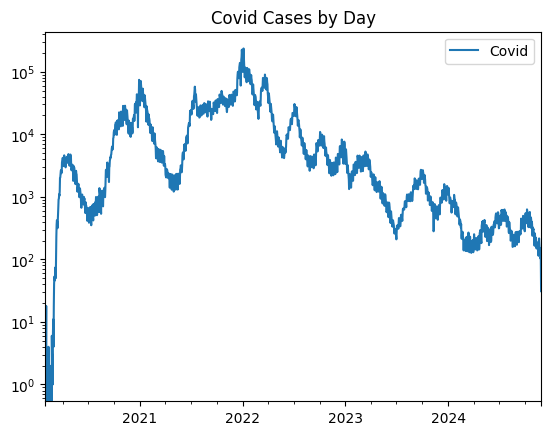

In [26]:

display(apibutton)
newDf = covidDf.plot(logy=True)
newDf.set_title('Covid Cases by Day')



In [22]:
pickGraph=wdg.RadioButtons(
    options=['2022', '2023', '2024'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Pick A Graph',
    disabled=False
)

radio_controls=wdg.VBox([pickGraph])

def radioGraph(graph):
    if graph=='2022':
        newDf = wrangle_data(deaths_2022).plot(logy=True)# df is the dataframe for plotting
        newDf.set_title('Deaths in 2022')
        newDf.set_ylabel('Number of deaths(log(n))')
        newDf.set_xlabel('Year')
        plt.show()
    elif graph=='2023':
        newDf = wrangle_data(deaths_2023).plot(logy=True)
        newDf.set_title('Number of Deaths in 2023')
        newDf.set_ylabel('Number of deaths (log(n))')
        newDf.set_xlabel('Year')
        plt.show()
    elif graph=='2024':
        newDf = wrangle_data(deaths_2024).plot(logy=True)
        newDf.set_title('Number of Deaths in 2024')
        newDf.set_ylabel('Number of death in log(n)')
        newDf.set_xlabel('Year')
        plt.show()
    else:
        print('Invalid selection')

pick_graph=wdg.interactive(radioGraph, graph=pickGraph)

display(pick_graph)


interactive(children=(RadioButtons(description='Pick A Graph', options=('2022', '2023', '2024'), value='2022')…

SHOW ALL DATA AND COMPARE

In [23]:
# in the dashboard, this should be computed from the json files
alldatadfpk=pd.read_pickle("allData.pkl")

series=wdg.SelectMultiple(
    options=['cases', 'admissions', 'deaths', 'influenzaAdmissions', 'bedsDay','CovidPCR', 'influenzaPCR'],
    value=['cases', 'admissions', 'deaths', 'influenzaAdmissions', 'bedsDay','CovidPCR', 'influenzaPCR'],
    rows=2,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

# try replacing HBox with a VBox
controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        alldatadfpk[list(gcols)].plot(logy=logscale)
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); 
# capture output in widget graph   
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()

In [24]:
#covid cases by day and beds
# in the dashboard, this should be computed from the json files
timeseriesdf=pd.read_pickle("covidDayBeds.pkl")

series=wdg.SelectMultiple(
    options=['beds', 'covidCases'],
    value=['beds', 'covidCases'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

# try replacing HBox with a VBox
controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); 
# capture output in widget graph   
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()